# Introduction

In this notebook, I continue from the EDA carried out by Imran. In his notebook, he perfoms some feature analysis as well as some statistical tests to test whether the pollution data displays stationarity. These tests that indicate stationarity are important as this is a very important assumption in Vector Autoregressive (VAR) models.

VAR models are the multivariate generalisation of univariate autoregressive time series models. In general, the prediction vector $y_{t}$ depennds on its $p$ previous values $y_{t-1}, y_{t-2},...,y_{t-p}$. These quantities are related in a linear form as shown below $$y_{t} = a_{0} + \sum_{j=1}^{p}A_{j}y_{t-j} + u_{t}$$
where $y_{t} \in \mathbb{R}^{n}$ vector containing the values of the different time series at time $T=t$, $a_{0} \in \mathbb{R}^{n}$ is a vector of constants, $A_{1} \in \mathbb{R}^{n \times n}$ are the autoregressive coefficients that and $u_{t} \in \mathbb{R}^{n}$ represents noise. 

The ultimate goal is to find the "best" lag $p$ and to fit the ``best" possible autoregressive coefficients. We discuss what is mean by the term "best" in terms of lag and autoregressive coefficients.


First, we just do some preprocessing that was already carried out in the previous notebook.

In [231]:
import numpy as np
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [22]:
with open('../data/raw_data.pickle', 'rb') as f:
    df = pickle.load(f)

In [92]:
df

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,3,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,3,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,3,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,3,246.72,0,0


In [24]:
df = df.rename_axis('date').reset_index()

In [25]:
mapping = {
    'NE': 1,
    'SE': 2,
    'NW': 3,
    'cv': 4
}

df.wnd_dir = df.wnd_dir.map(mapping)
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


## Chosing The Lag $p$

In our model, it is rather pertinent to choose a good value for $p$. By a good value, we mean a value that is long enough such that we can effectively utilise the data we have acquired but not so large such that we creat a model that overfits.

A useful way to see what lag we should use is by plotting autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. These plots tell us how correlated (~ "predictive") the values at time $T=t-p$ are to values at $T=t$. More specifically, ACF plots show the correlation of a time series with itself at different lags. Alternatively, PACF plots show the correlation of a time series with itself at different lags but without for any correlation between observations of short lags. It turns out that PACF are usually more descriptive so we only plot those below.

Note that as we are working with multiple times series (population, dew, temp, etc), we need to the PACF plots for each.

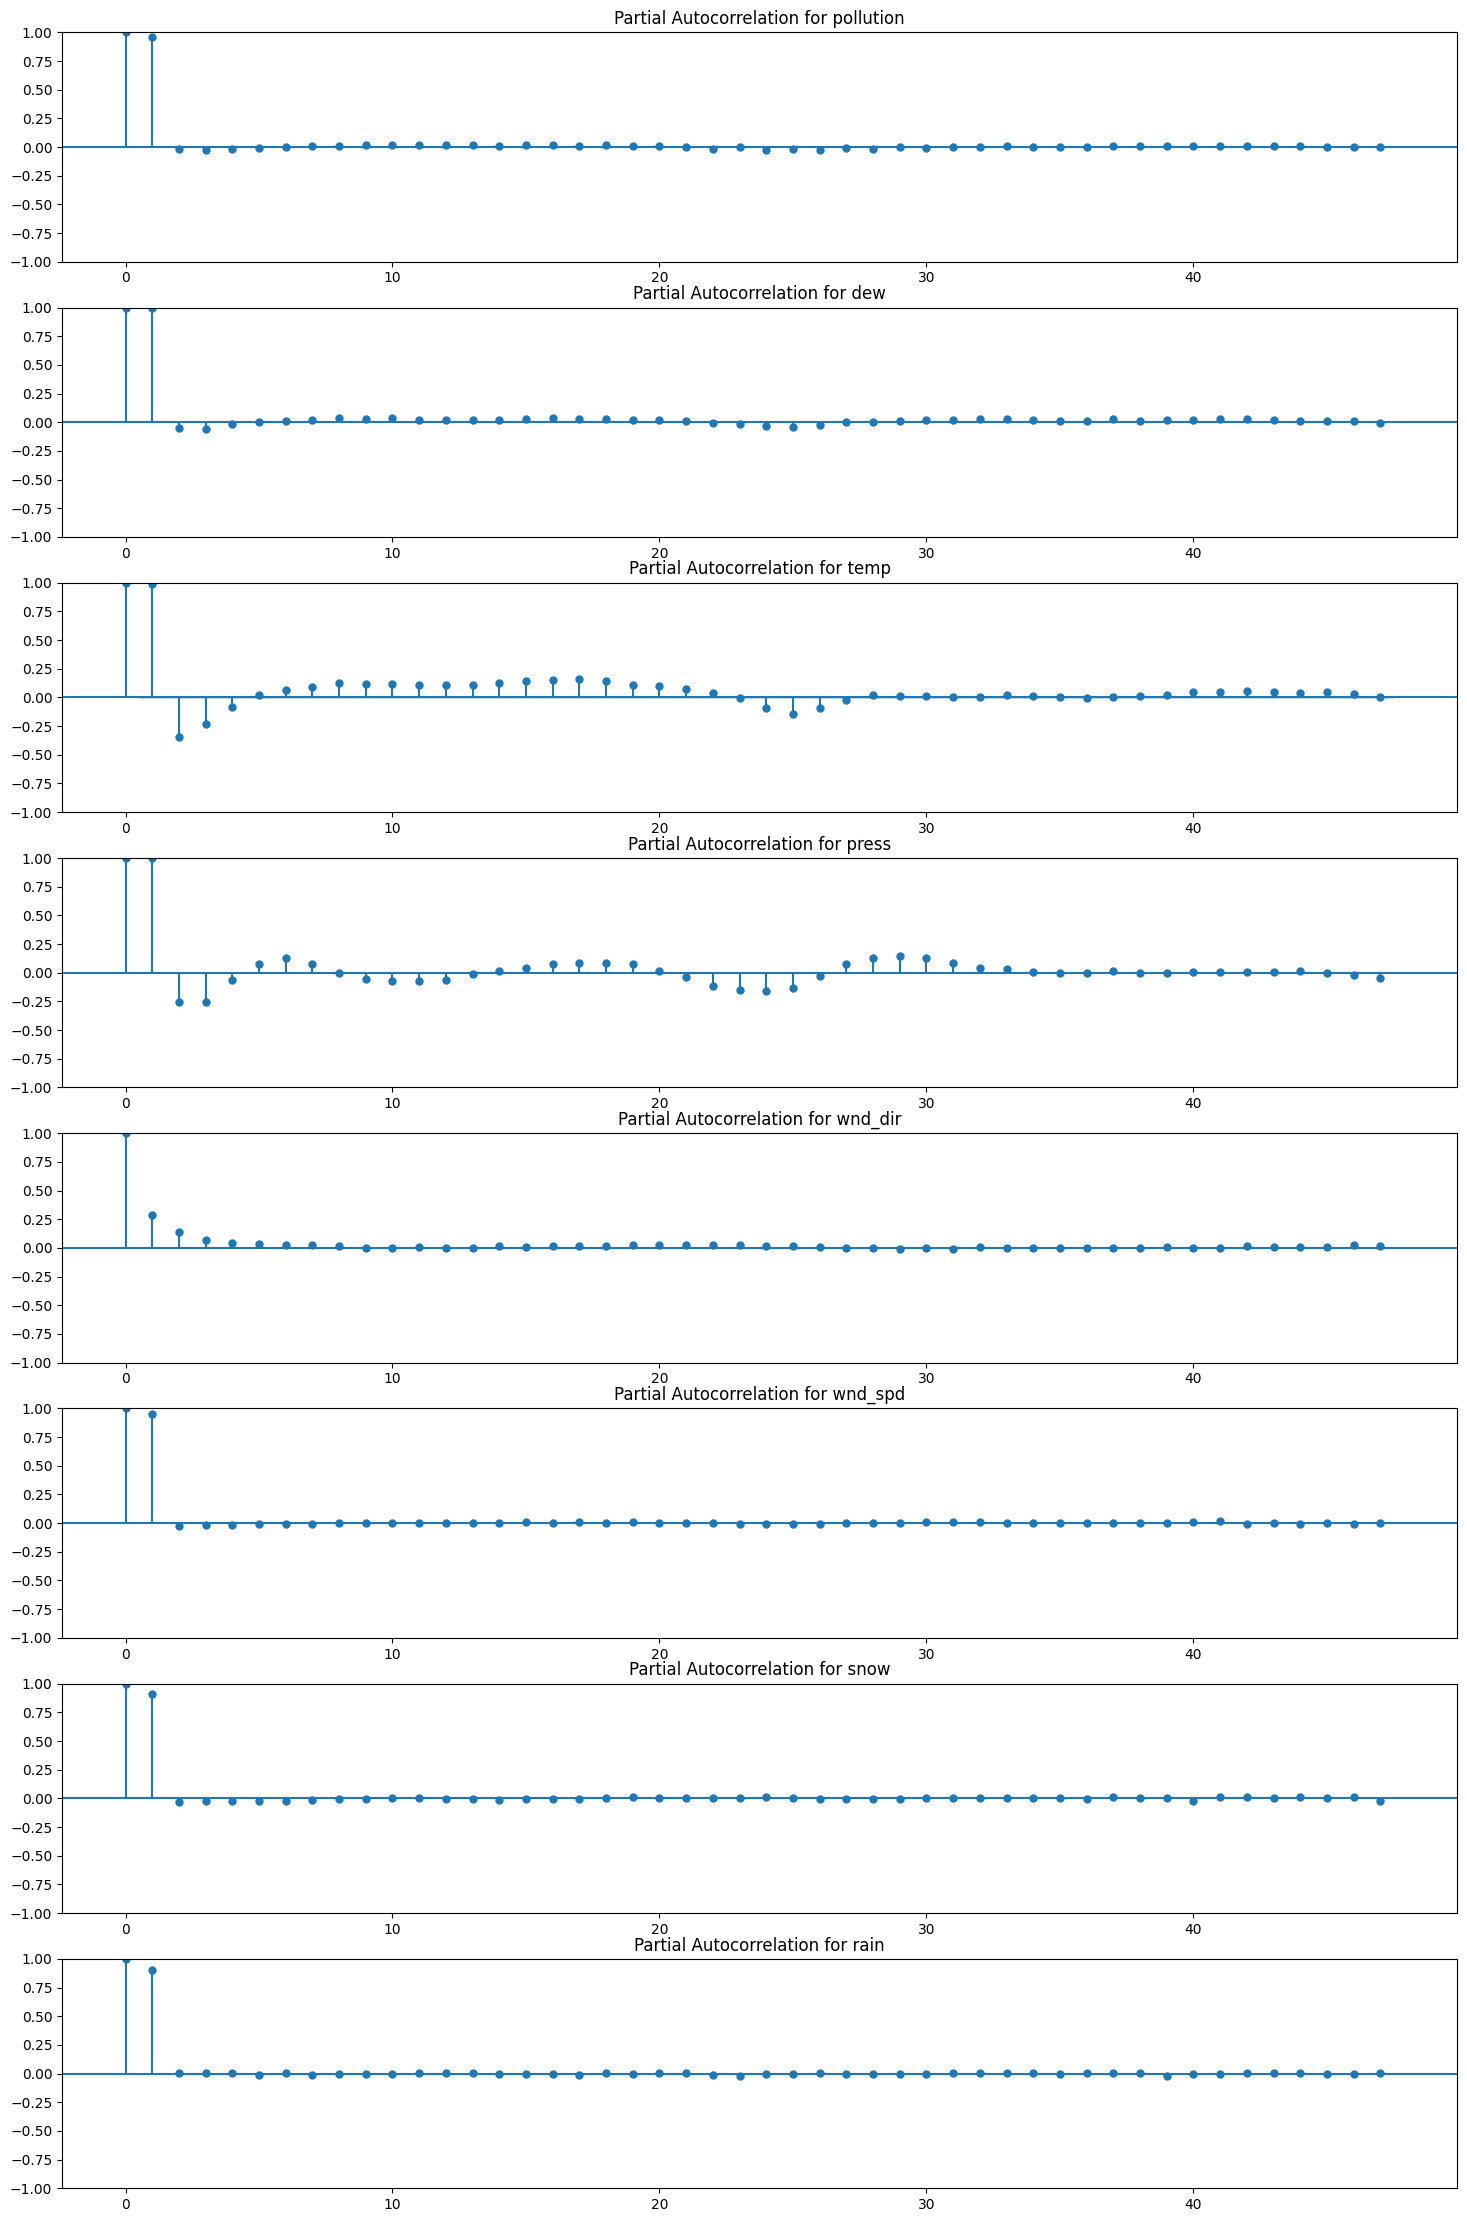

In [202]:
fig, axs = plt.subplots(8, 1, figsize=(18,28))

columns = list(df)
columns.pop(0)
for i, x in enumerate(columns):
    plot_pacf(df[x], axs[i], title="Partial Autocorrelation for " + x)

# ANALYSIS
We see that $p$ should be pretty small. We see that there is some seasonal effect for pressure. Maybe we could do some modular arithmetic lag. I am not sure but anyway, after $p=4$, I don't think we have anything significant. #Expand on this

Look up what the context means

## Finding Optimal Lags
While these PACF plots do provide a heuristic for finding a good choice for out lag $p$, we can use other methods that provide a more systematic approach. First, we look at some error metrics. In particular, we look at mean absolute error (MAE) and root mean square error (RMSE). Their formulae are below:
* $MAE = \sum_{j=1}^{n} |y_{t} - \hat{y_{t}}|$
* $RMSE = \sqrt{\sum_{j=1}^{n}(y_{t} - \hat{y_{t}})^{2}}$
While there are other 
to Namely, we can use information criterion to evaluate which model is the best.

To do this, we create a 80/10/10  train, validation, test split. We will train a model with the training data. Use ``results.forecast`` on validation data using rolling window validation on different lags with different information criteria.

Recall that you are reading: https://phdinds-aim.github.io/time_series_handbook/03_VectorAutoregressiveModels/03_VectorAutoregressiveMethods.html#building-a-var-model

In [ ]:
forecast_length = len(df) // 10

# Creating an 80/10/10 train, validation, test split 
train_df, validation_df, test_df = df[0: 8*forecast_length], df[8*forecast_length: 9*forecast_length], df[9*forecast_length:]

train_df = train_df.drop("date", axis=1)
validation_df = validation_df.drop("date", axis=1)
test_df = test_df.drop("date", axis=1)

In [ ]:
# Train the model
model = VAR(train_df)

In [ ]:
# Finding the MAE error and RMSE error with respect to different lags
sums_of_errors1, sums_of_errors = [], []
for j in range(1, 30):
    results = model.fit(j)

    validation_length = 100
    arr1, arr = [], []
    for i in range(len(validation_df) - validation_length - 1):
        arr1.append(mean_absolute_error(results.forecast(validation_df.values[i:i + validation_length], steps=1)[0], validation_df.values[i + validation_length + 1]))
        arr.append(root_mean_squared_error(results.forecast(validation_df.values[i:i + validation_length], steps=1)[0], validation_df.values[i + validation_length + 1]))

    sums_of_errors1.append(sum(arr1))
    sums_of_errors.append(sum(arr))

Text(0.5, 1.0, 'Mean Squared Error on Validation Data For Lag Value')

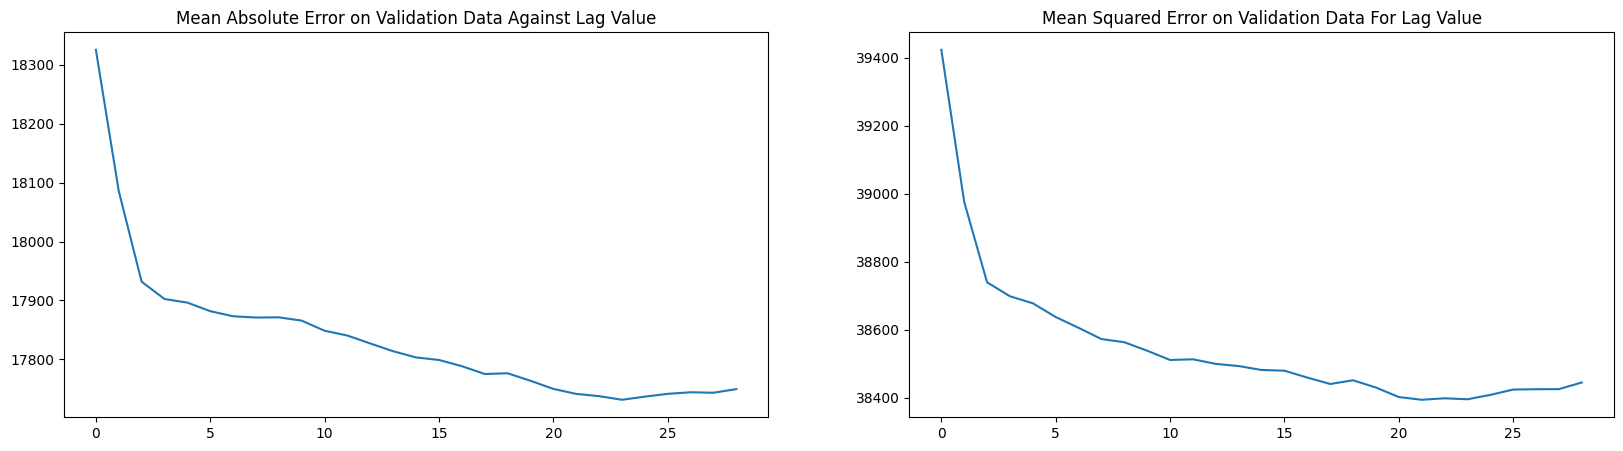

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].plot([i for i in range(len(sums_of_errors1))], sums_of_errors1)
axs[0].set_title("Mean Absolute Error on Validation Data Against Lag Value")
axs[1].plot([i for i in range(len(sums_of_errors))], sums_of_errors)
axs[1].set_title("Mean Squared Error on Validation Data For Lag Value")

From these plots, it seems that a lag of $p=23$ minimises our error when we test against our validation data. This some what contradicts the conclusion we drew from the PACF plots. ## Analyse why this might be

We now look at using information criteria to try to determine the optimal lag. 
"Akaike Information Criterion (AIC), Schwarz’s Bayesian Information Criterion (BIC), Hannan-Quinn Criterion (HQ), and Akaike’s Final Prediction Error Criterion (FPE)."


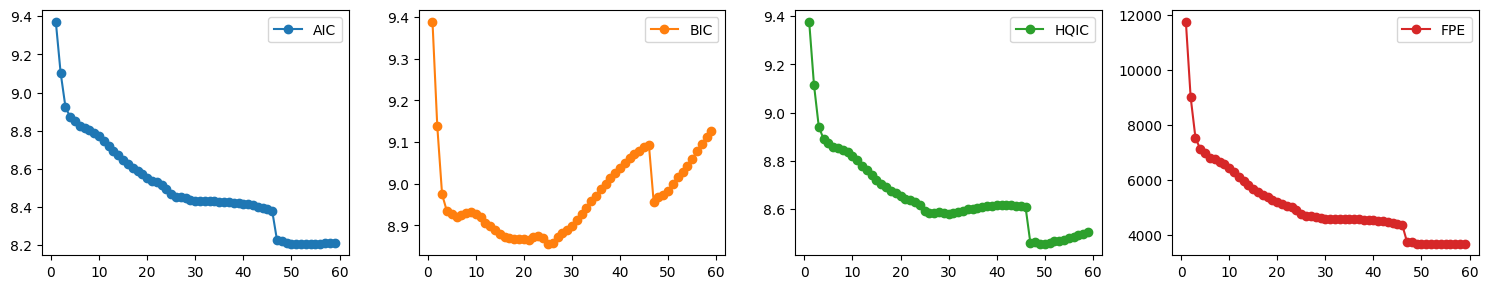

In [ ]:
aic, bic, fpe, hqic = [], [], [], []
model = VAR(train_df) 
p = np.arange(1,60)
for i in p:
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)
    fpe.append(result.fpe)
    hqic.append(result.hqic)
lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                'BIC': bic, 
                                'HQIC': hqic,
                                'FPE': fpe}, 
                               index=p)    
fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
plt.tight_layout()

I think this plot is the most enlightening. It shows that each information criterion decays rapidly for lags less than four but once we reach four, the loss in information is somewhat minimal. 

## The Granger Causality Test

The Granger causality test